<h2> Perturbation theory to approximate and infinite square well with a linear term V(x) = alpha x </h2>

<h3> Finding the second order pertubed energy levels for the ground state </h3>

In [20]:
import math
import scipy.constants as sc
import numpy as np
import matplotlib.pyplot as plt


"""
Calculating the energy for any n without an added perturbation
n       = number of excited state
mass    = mass of particle in the well
length  = length of the well
"""
def unperturbed_energy(n, mass, length):
    numerator = math.pow(n,2) * math.pow(np.pi, 2) * math.pow(sc.hbar, 2)
    denominator = 2 * mass * math.pow(length, 2)

    return numerator / denominator

"""
Calculating the first order correction.
Found by solving ⟨1|V1|1⟩
This correction is generalized for all n, as it does not take n into account
"""
def first_order_correction(alpha, length):
    numerator = alpha * length

    return numerator / 2


"""
Calculating the second order correction for the ground state.
Found by solving:
        a^2 SUM(m=/=n) |⟨n|V1|n⟩|^2 / E(0)n - E(0)m
"""
def second_order_correction_groundstate(alpha, mass, length, max_n=10):
    # Split into left-hand-side (LHS) and right-hand-side(RHS) which is the sum over even n
    numerator = -128 * mass * (length**4) * (alpha**2)
    denominator = (np.pi**6) * (sc.hbar**2)
    prefactor = numerator / denominator

    # Now summing over even n
    sum_range = range(2,max_n, 2)
    sum_result = 0.0
    for n in sum_range:
        temp = (n**2) / (((n-1)**5) * ((n+1)**5))
        sum_result+=temp

    
    return prefactor * sum_result

""" 
Combining the unperturbed energy with the 2 corrections for our final result
"""
def energy_groundstate_second_order_perturbation(e01, e11, e21):
    return e01 + e11 + e21
    

6.024667394036591e-20
0.3760301621048726


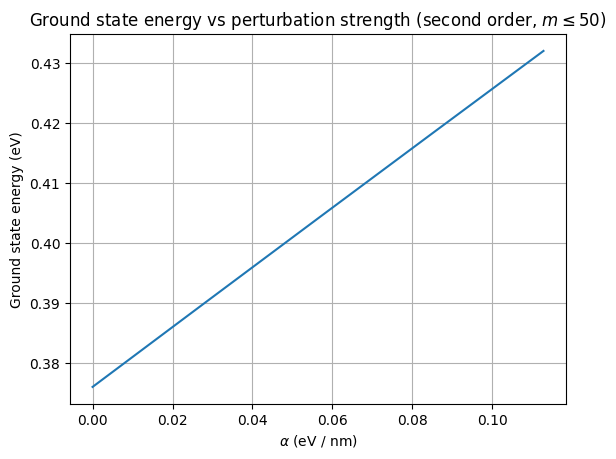

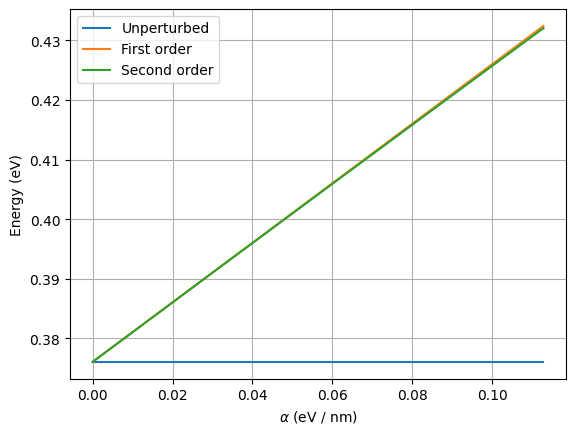

2 -0.0
4 -0.00036601542839890465
6 -0.00036648392814725525
10 -0.0003665006028672353
20 -0.0003665009130126121
50 -0.0003665009147609417


In [ ]:
particle_mass = sc.electron_mass # using an electron
well_length = 1e-9

ground_state = unperturbed_energy(1,particle_mass,well_length)
print(ground_state) # this is in joules
print(ground_state / sc.electron_volt) # this is in electron volts eV

""" 
We choose alpha such that the first-order perturbative correction becomes comparable to the unperturbed level spacing
"""
alpha_min = 0
delta_E = (3 * (np.pi**2) * (sc.hbar**2)) / (2 * particle_mass * (well_length**2))
alpha_max = delta_E  / well_length
num_steps = 200
alpha_values = np.linspace(alpha_min, alpha_max, num_steps)

E0 = unperturbed_energy(1, particle_mass, well_length)

# list of ground state energies for different alphas
E_ground = []

for alpha in alpha_values:
    E1 = first_order_correction(alpha, well_length)
    E2 = second_order_correction_groundstate(
        alpha,
        particle_mass,
        well_length,
        max_n=50
    )
    E_ground.append(E0 + E1 + E2)

# Array of all ground-state energy levels in joules for range of alpha values
E_ground = np.array(E_ground)

# From joules to eV
E_ground_ev = E_ground / sc.electron_volt
alpha_ev_per_nm = alpha_values * well_length / sc.electron_volt

plt.figure()
plt.plot(alpha_ev_per_nm, E_ground_ev)
plt.xlabel(r'$\alpha$ (eV / nm)')
plt.ylabel('Ground state energy (eV)')
plt.title('Ground state energy vs perturbation strength (second order, $m \\leq 50$)')
plt.grid(True)
plt.show()


E_first_only = E0 + alpha_values * well_length / 2

plt.figure()
plt.plot(alpha_ev_per_nm, E0 / sc.electron_volt * np.ones_like(alpha_values))
plt.plot(alpha_ev_per_nm, E_first_only / sc.electron_volt)
plt.plot(alpha_ev_per_nm, E_ground_ev)

plt.xlabel(r'$\alpha$ (eV / nm)')
plt.ylabel('Energy (eV)')
plt.legend(['Unperturbed', 'First order', 'Second order'])
plt.grid(True)
plt.show()


for max_n in [2, 4, 6, 10, 20, 50]:
    E2 = second_order_correction_groundstate(alpha_max, particle_mass, well_length, max_n)
    print(max_n, E2 / sc.electron_volt)


<h3> Finding the energy levels of the first excited state to second order using perturbation theory </h3>

In [22]:

"""
alpha   = alpha value
mass    = mass of particle
length  = length of the well
max_m   = maximum number of iterations on the sum
"""
def second_order_correction_first_excited_state(alpha, mass, length, max_m):
    # Split into left-hand-side (LHS) and right-hand-side(RHS) which is the sum over even n
    numerator = -512 * mass * (length**4) * (alpha**2)
    denominator = (np.pi**6) * (sc.hbar**2)
    prefactor = numerator / denominator

    # Now summing over even n
    sum_range = range(1, max_m + 1, 2)
    sum_result = 0.0
    for n in sum_range:
        temp = (n**2) / (((n-2)**5) * ((n+2)**5))
        sum_result+=temp

    return prefactor * sum_result

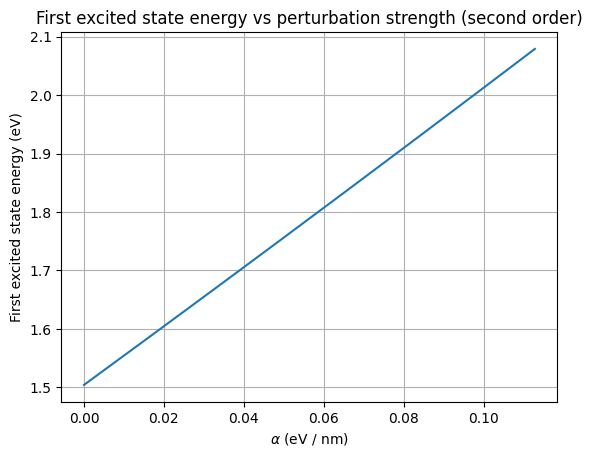

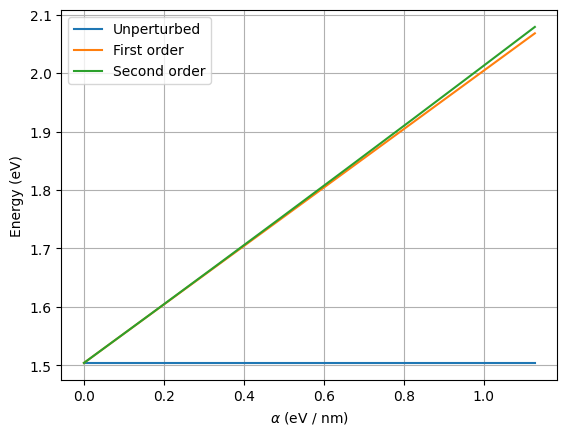

1 0.03660154283989046
3 0.01098631909882152
5 0.010931875202171478
10 0.010929247267115689
20 0.010929180173330841
50 0.01092917967004415


In [38]:
# unperturbed energy and 1st order correction energy calculation functions have already been defined

# this means E(0)2, the unperturbed energy of the first excited state
E02 = unperturbed_energy(2, particle_mass, well_length)

alpha_min = 0
delta_E2 = (3 * (np.pi**2) * (sc.hbar**2)) / (2 * particle_mass * (well_length**2))
alpha_max = delta_E2 / well_length
num_steps = 200
alpha_values = np.linspace(alpha_min, alpha_max, num_steps)

E02 = unperturbed_energy(2, particle_mass, well_length)

E2_excited = []

for alpha in alpha_values:
    E12 = first_order_correction(alpha, well_length)
    E22 = second_order_correction_first_excited_state(
        alpha,
        particle_mass,
        well_length,
        max_m=50
    )
    E2_excited.append(E02 + E12 + E22)

E2_excited = np.array(E2_excited)
E2_excited_ev = E2_excited / sc.electron_volt

plt.figure()
plt.plot(alpha_ev_per_nm, E2_excited_ev)
plt.xlabel(r'$\alpha$ (eV / nm)')
plt.ylabel('First excited state energy (eV)')
plt.title('First excited state energy vs perturbation strength (second order)')
plt.grid(True)
plt.show()



E2_first_only = E02 + alpha_values * well_length / 2
alpha_ev_per_nm = alpha_values * well_length / sc.electron_volt


plt.figure()
plt.plot(alpha_ev_per_nm, E02 / sc.electron_volt * np.ones_like(alpha_values))
plt.plot(alpha_ev_per_nm, E2_first_only / sc.electron_volt)
plt.plot(alpha_ev_per_nm, E2_excited_ev)

plt.xlabel(r'$\alpha$ (eV / nm)')
plt.ylabel('Energy (eV)')
plt.legend(['Unperturbed', 'First order', 'Second order'])
plt.grid(True)
plt.show()



for max_m in [1, 3, 5, 10, 20, 50]:
    E22 = second_order_correction_first_excited_state(
        alpha_max,
        particle_mass,
        well_length,
        max_m=max_m
    )
    print(max_m, E22 / sc.electron_volt)


<h3> Plotting wave functions in an infinite square well </h3>

In [26]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
from numpy.linalg import eigh

# Physical parameters
m = sc.electron_mass
L = 1e-9
N = 400  # grid points (increase for smoother curves)

x = np.linspace(0, L, N)
dx = x[1] - x[0]

# Kinetic energy matrix
coeff = sc.hbar**2 / (2 * m * dx**2)
T = coeff * (
    2 * np.eye(N)
    - np.eye(N, k=1)
    - np.eye(N, k=-1)
)

def hamiltonian(alpha):
    V = np.diag(alpha * x)
    return T + V

def compute_wavefunctions(alpha):
    H = hamiltonian(alpha)
    energies, states = eigh(H)
    return energies, states


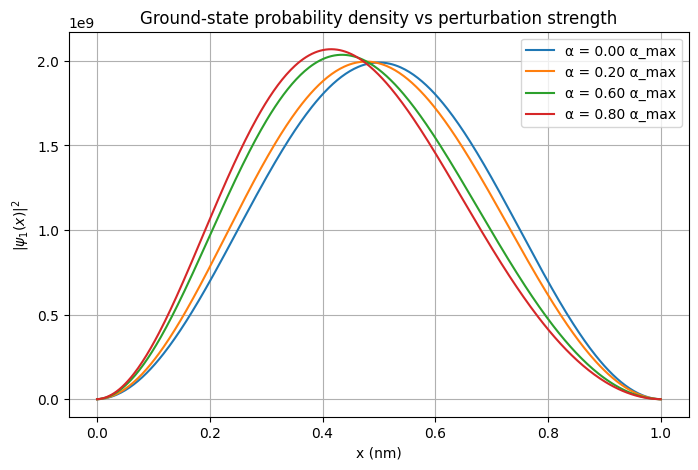

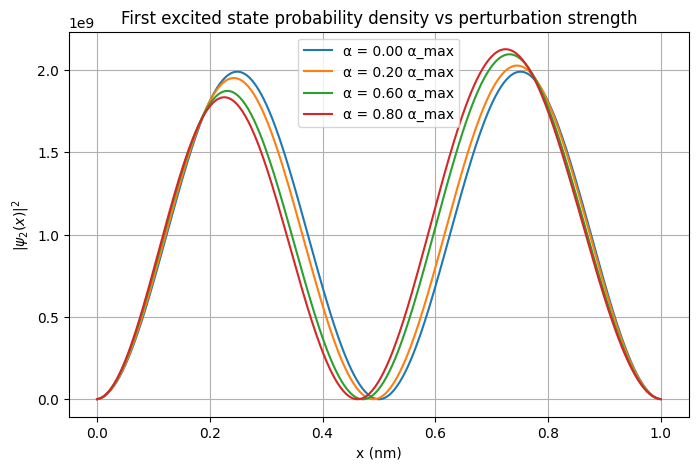

In [30]:
alpha_values = [0, 0.2, 0.6, 0.8]  # in units of alpha_max
delta_E = (3 * np.pi**2 * sc.hbar**2) / (2 * m * L**2)
alpha_max = delta_E / L
alpha_values = [a * alpha_max for a in alpha_values]

plt.figure(figsize=(8,5))

for alpha in alpha_values:
    E, psi = compute_wavefunctions(alpha)
    psi1 = psi[:, 0]
    psi1 /= np.sqrt(np.trapezoid(psi1**2, x))  # normalize

    plt.plot(x * 1e9, psi1**2, label=f'α = {alpha/alpha_max:.2f} α_max')

plt.xlabel('x (nm)')
plt.ylabel(r'$|\psi_1(x)|^2$')
plt.title('Ground-state probability density vs perturbation strength')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8,5))

for alpha in alpha_values:
    E, psi = compute_wavefunctions(alpha)
    psi1 = psi[:, 1]
    psi1 /= np.sqrt(np.trapezoid(psi1**2, x))  # normalize

    plt.plot(x * 1e9, psi1**2, label=f'α = {alpha/alpha_max:.2f} α_max')

plt.xlabel('x (nm)')
plt.ylabel(r'$|\psi_2(x)|^2$')
plt.title('First excited state probability density vs perturbation strength')
plt.legend()
plt.grid(True)
plt.show()


<h3> Justifying truncation </h3>

In [39]:
import numpy as np
import scipy.constants as sc

def E0(n, mass, L):
    return (n**2 * np.pi**2 * sc.hbar**2) / (2 * mass * L**2)

def x_me_1(m, L):
    # <m|x|1> for even m (0 for odd m)
    if m % 2 == 1:
        return 0.0
    return -(8 * m * L) / (np.pi**2 * (m-1)**2 * (m+1)**2)

def term_ground(m, alpha, mass, L):
    if m == 1:
        return 0.0
    xm1 = x_me_1(m, L)
    if xm1 == 0.0:
        return 0.0
    denom = E0(1, mass, L) - E0(m, mass, L)
    return (alpha**2) * (xm1**2) / denom


In [40]:
def x_me_2(m, L):
    # <m|x|2> for odd m (0 for even m)
    if m % 2 == 0:
        return 0.0
    return -(16 * m * L) / (np.pi**2 * (m-2)**2 * (m+2)**2)

def term_excited(m, alpha, mass, L):
    if m == 2:
        return 0.0
    xm2 = x_me_2(m, L)
    if xm2 == 0.0:
        return 0.0
    denom = E0(2, mass, L) - E0(m, mass, L)
    return (alpha**2) * (xm2**2) / denom


In [41]:
particle_mass = sc.electron_mass
L = 1e-9

delta_E = E0(2, particle_mass, L) - E0(1, particle_mass, L)
alpha_max = delta_E / L  # your chosen scaling

alpha = alpha_max


In [42]:
# Ground state terms: m = 2,4,6,... up to M
M_ground = 50
m_vals_g = np.arange(2, M_ground+1, 2)
terms_g = np.array([term_ground(m, alpha, particle_mass, L) for m in m_vals_g])
partials_g = np.cumsum(terms_g)

# First excited terms: m = 1,3,5,... up to M
M_exc = 51
m_vals_e = np.arange(1, M_exc+1, 2)
terms_e = np.array([term_excited(m, alpha, particle_mass, L) for m in m_vals_e])
partials_e = np.cumsum(terms_e)

# Convert to eV for readability
terms_g_ev = terms_g / sc.electron_volt
partials_g_ev = partials_g / sc.electron_volt

terms_e_ev = terms_e / sc.electron_volt
partials_e_ev = partials_e / sc.electron_volt


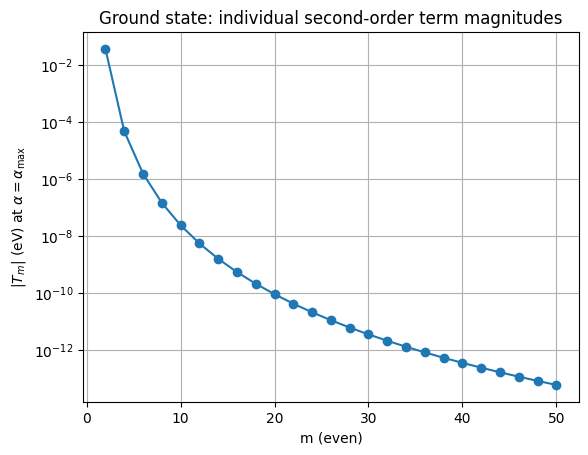

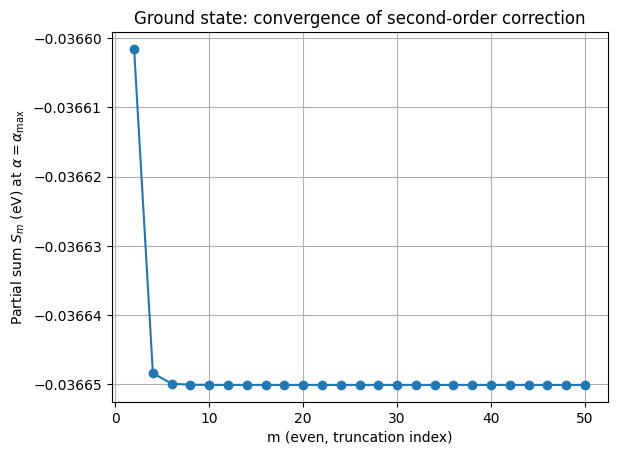

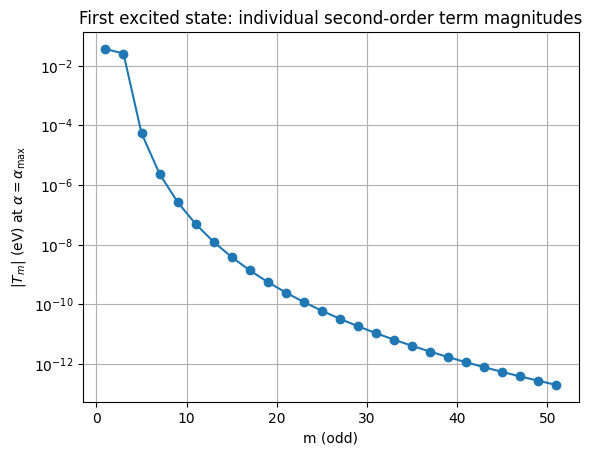

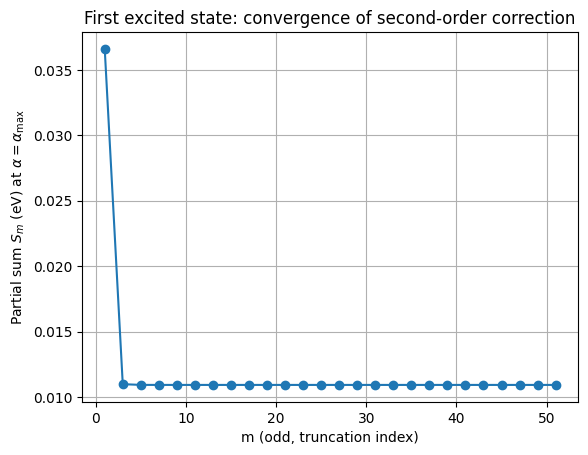

In [43]:
import matplotlib.pyplot as plt

# Individual term magnitudes (ground)
plt.figure()
plt.plot(m_vals_g, np.abs(terms_g_ev), marker='o')
plt.yscale('log')
plt.xlabel('m (even)')
plt.ylabel(r'$|T_m|$ (eV) at $\alpha=\alpha_{\max}$')
plt.title('Ground state: individual second-order term magnitudes')
plt.grid(True)
plt.show()

# Partial sum convergence (ground)
plt.figure()
plt.plot(m_vals_g, partials_g_ev, marker='o')
plt.xlabel('m (even, truncation index)')
plt.ylabel(r'Partial sum $S_m$ (eV) at $\alpha=\alpha_{\max}$')
plt.title('Ground state: convergence of second-order correction')
plt.grid(True)
plt.show()

# Individual term magnitudes (excited)
plt.figure()
plt.plot(m_vals_e, np.abs(terms_e_ev), marker='o')
plt.yscale('log')
plt.xlabel('m (odd)')
plt.ylabel(r'$|T_m|$ (eV) at $\alpha=\alpha_{\max}$')
plt.title('First excited state: individual second-order term magnitudes')
plt.grid(True)
plt.show()

# Partial sum convergence (excited)
plt.figure()
plt.plot(m_vals_e, partials_e_ev, marker='o')
plt.xlabel('m (odd, truncation index)')
plt.ylabel(r'Partial sum $S_m$ (eV) at $\alpha=\alpha_{\max}$')
plt.title('First excited state: convergence of second-order correction')
plt.grid(True)
plt.show()


In [44]:
def truncation_report(partials, m_vals, label, target_m_list):
    full = partials[-1]
    print(f"\n{label}: Full (up to m={m_vals[-1]}) = {full/sc.electron_volt:.6e} eV")
    for tm in target_m_list:
        idx = np.where(m_vals == tm)[0]
        if len(idx) == 0:
            continue
        approx = partials[idx[0]]
        rel = abs((full - approx) / full) if full != 0 else np.nan
        print(f"  Up to m={tm}: {approx/sc.electron_volt:.6e} eV, relative diff = {rel:.3e}")

truncation_report(partials_g, m_vals_g, "Ground state E1^(2)", target_m_list=[2,4,6,10,20,50])
truncation_report(partials_e, m_vals_e, "First excited E2^(2)", target_m_list=[1,3,5,9,19,51])



Ground state E1^(2): Full (up to m=50) = -3.665009e-02 eV
  Up to m=2: -3.660154e-02 eV, relative diff = 1.325e-03
  Up to m=4: -3.664839e-02 eV, relative diff = 4.635e-05
  Up to m=6: -3.664992e-02 eV, relative diff = 4.763e-06
  Up to m=10: -3.665008e-02 eV, relative diff = 2.130e-07
  Up to m=20: -3.665009e-02 eV, relative diff = 2.372e-09
  Up to m=50: -3.665009e-02 eV, relative diff = 0.000e+00

First excited E2^(2): Full (up to m=51) = 1.092918e-02 eV
  Up to m=1: 3.660154e-02 eV, relative diff = 2.349e+00
  Up to m=3: 1.098632e-02 eV, relative diff = 5.228e-03
  Up to m=5: 1.093188e-02 eV, relative diff = 2.466e-04
  Up to m=9: 1.092925e-02 eV, relative diff = 6.185e-06
  Up to m=19: 1.092918e-02 eV, relative diff = 4.607e-08
  Up to m=51: 1.092918e-02 eV, relative diff = 0.000e+00
